<a href="https://colab.research.google.com/github/MBrandao07/Previsao_Demandas_Market_Show/blob/main/Codigos/4_Projeto_Previs%C3%A3o_Demanda_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5- Modelagem - Aperfeiçoando o modelo

## Funções

In [ ]:
# Função para gerar os metadados do dataframe
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

### Instalando as bibliotecas necessárias

In [ ]:
!pip install catboost
!pip install optuna

### Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import lightgbm as lgb
import catboost as cb
import joblib
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import optuna
from optuna.samplers import TPESampler
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

# Suprimir os alertas do LightGBM
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

### Conectando ao google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importando as bases de dados

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/train_data_fs.csv')
val = pd.read_csv('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/val_data_fs.csv')

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type_stores,...,rolling_mean_180,rolling_mean_360,year,month,day,day_of_week,is_weekend,sales_oil_price_interaction_mult,sales_oil_price_interaction_div,target
0,650430,2014-01-02,1,AUTOMOTIVE,3.0,0,95.14,Quito,Pichincha,D,...,5.805908,5.971493,2014,1,2,3,False,285.42,0.031532,31.0
1,652212,2014-01-03,1,AUTOMOTIVE,0.0,0,93.66,Quito,Pichincha,D,...,5.805908,5.971493,2014,1,3,4,False,0.00,0.000000,35.0
2,653994,2014-01-04,1,AUTOMOTIVE,0.0,0,93.12,Quito,Pichincha,D,...,5.805908,5.971493,2014,1,4,5,True,558.72,0.064433,35.0
3,655776,2014-01-05,1,AUTOMOTIVE,1.0,0,93.12,Quito,Pichincha,D,...,5.805908,5.971493,2014,1,5,6,True,558.72,0.064433,36.0
4,657558,2014-01-06,1,AUTOMOTIVE,6.0,0,93.12,Quito,Pichincha,D,...,5.805908,5.971493,2014,1,6,0,False,558.72,0.064433,39.0


In [ ]:
val.head()

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type_stores,...,rolling_mean_180,rolling_mean_360,year,month,day,day_of_week,is_weekend,sales_oil_price_interaction_mult,sales_oil_price_interaction_div,target
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,52.36,Quito,Pichincha,D,...,3.961111,4.355556,2017,1,1,6,True,209.44,0.076394,45.0
1,2598156,2017-01-02,1,AUTOMOTIVE,5.0,0,52.36,Quito,Pichincha,D,...,3.955556,4.355556,2017,1,2,0,False,209.44,0.076394,42.0
2,2599938,2017-01-03,1,AUTOMOTIVE,4.0,0,52.36,Quito,Pichincha,D,...,3.966667,4.352778,2017,1,3,1,False,209.44,0.076394,41.0
3,2601720,2017-01-04,1,AUTOMOTIVE,1.0,0,53.26,Quito,Pichincha,D,...,3.955556,4.338889,2017,1,4,2,False,53.26,0.018776,42.0
4,2603502,2017-01-05,1,AUTOMOTIVE,2.0,0,53.77,Quito,Pichincha,D,...,3.916667,4.341667,2017,1,5,3,False,107.54,0.037195,42.0


In [ ]:
generate_metadata(train)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,180180
1,date,object,0,0.0,1092
2,store_nbr,int64,0,0.0,5
3,family,object,0,0.0,33
4,sales,float64,0,0.0,44453
5,onpromotion,int64,0,0.0,223
6,oil_price,float64,0,0.0,676
7,city,object,0,0.0,2
8,state,object,0,0.0,2
9,type_stores,object,0,0.0,1


In [ ]:
generate_metadata(val)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,22440
1,date,object,0,0.0,136
2,store_nbr,int64,0,0.0,5
3,family,object,0,0.0,33
4,sales,float64,0,0.0,7494
5,onpromotion,int64,0,0.0,163
6,oil_price,float64,0,0.0,83
7,city,object,0,0.0,2
8,state,object,0,0.0,2
9,type_stores,object,0,0.0,1


## Treinando novos modelos utilizando a base com novas features

### Treinando modelos com a base completa

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

# Separar as colunas numéricas e categóricas
numeric_features = train[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train[features].select_dtypes(include=['object']).columns

train.loc[:,categorical_features] = train[categorical_features].astype(str)


X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df1 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df1

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 7.70 segundos
RMSE no treino: 3766.664101756439 
RMSE no teste: 1812.0674159011817 
MAE no treino: 904.5969004366187 
MAE no teste: 640.1510599159952 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 7.53 segundos


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSE no treino: 1315.674993490273 
RMSE no teste: 2418.8522362932085 
MAE no treino: 440.7409385773409 
MAE no teste: 635.7976879519291 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 17.77 segundos
RMSE no treino: 2096.714211994752 
RMSE no teste: 2009.7931582013578 
MAE no treino: 671.8343395956707 
MAE no teste: 648.9046297063361 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamento: 316.40 segundos
RMSE no treino: 2487.1098060041377 
RMSE no teste: 1903.64495609101 
MAE no treino: 706.8217125141052 
MAE no teste: 615.4992488027085 
----------------------------------------------------------------------
Treinando o algoritmo: XGBoost
Treino finalizado. Tempo gasto no treinamento: 5.17 segundos
RMSE no treino: 728.5271880736059 
RMSE no teste: 2294.1587349604347 
MAE no treino: 307

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3766.664102,1812.067416,904.596900,640.151060
1,LightGBM,1315.674993,2418.852236,440.740939,635.797688
2,CatBoost,2096.714212,2009.793158,671.834340,648.904630
3,GradientBoosting,2487.109806,1903.644956,706.821713,615.499249
4,XGBoost,728.527188,2294.158735,307.181699,617.132085


### Treinando modelos com a base a partir de agosto de 2015

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

train_aux = train[train.date >= '2015-08-01'].copy()

# Separar as colunas numéricas e categóricas
numeric_features = train_aux[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_aux[features].select_dtypes(include=['object']).columns

train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)

X_train = train_aux[features]
y_train = train_aux[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df2 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df2

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 2.56 segundos
RMSE no treino: 3212.9447773936718 
RMSE no teste: 1783.7742307538674 
MAE no treino: 721.6877573736525 
MAE no teste: 785.74730790406 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 2.37 segundos


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSE no treino: 933.1647069355265 
RMSE no teste: 3816.312651717566 
MAE no treino: 326.30747827786814 
MAE no teste: 765.3878237962839 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 6.14 segundos
RMSE no treino: 1528.4466574551222 
RMSE no teste: 2694.2068540788064 
MAE no treino: 515.7079620835987 
MAE no teste: 723.2755907078027 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamento: 151.77 segundos
RMSE no treino: 1630.813818768987 
RMSE no teste: 1884.4179774078823 
MAE no treino: 493.49551678590643 
MAE no teste: 583.6131741429114 
----------------------------------------------------------------------
Treinando o algoritmo: XGBoost
Treino finalizado. Tempo gasto no treinamento: 2.87 segundos
RMSE no treino: 425.0291994100714 
RMSE no teste: 4170.061099317673 
MAE no treino: 19

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3212.944777,1783.774231,721.687757,785.747308
1,LightGBM,933.164707,3816.312652,326.307478,765.387824
2,CatBoost,1528.446657,2694.206854,515.707962,723.275591
3,GradientBoosting,1630.813819,1884.417977,493.495517,583.613174
4,XGBoost,425.029199,4170.061099,198.834495,851.838681


### Treinando modelos com a base a partir de janeiro de 2016

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

train_aux = train[train.date >= '2016-01-01'].copy()

# Separar as colunas numéricas e categóricas
numeric_features = train_aux[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_aux[features].select_dtypes(include=['object']).columns

train_aux.loc[:,categorical_features] = train_aux[categorical_features].astype(str)

X_train = train_aux[features]
y_train = train_aux[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir os modelos a serem testados
models = {
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Função para treinar e avaliar modelos
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        print(f'Treinando o algoritmo: {model_name}')
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Treino finalizado. Tempo gasto no treinamento: {elapsed_time:.2f} segundos')

        # Previsões no treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões no teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        results.append((model_name, train_rmse, test_rmse, train_mae, test_mae))
        print(f"RMSE no treino: {train_rmse} \n"
              f"RMSE no teste: {test_rmse} \n"
              f"MAE no treino: {train_mae} \n"
              f"MAE no teste: {test_mae} \n"
              f"{70*'-'}")

    return results

# Avaliar os modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test)

# Mostrar os resultados
results_df3 = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])

results_df3

Treinando o algoritmo: LinearRegression
Treino finalizado. Tempo gasto no treinamento: 0.65 segundos
RMSE no treino: 3454.46497841506 
RMSE no teste: 1698.4501243555815 
MAE no treino: 718.8151613004977 
MAE no teste: 778.8757644727689 
----------------------------------------------------------------------
Treinando o algoritmo: LightGBM
Treino finalizado. Tempo gasto no treinamento: 1.68 segundos


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSE no treino: 866.8864577225281 
RMSE no teste: 3838.5425007187077 
MAE no treino: 305.675255068825 
MAE no teste: 802.830991583719 
----------------------------------------------------------------------
Treinando o algoritmo: CatBoost
Treino finalizado. Tempo gasto no treinamento: 6.58 segundos
RMSE no treino: 1417.9728290186129 
RMSE no teste: 2852.9065298648575 
MAE no treino: 494.28180267502006 
MAE no teste: 766.6620479700458 
----------------------------------------------------------------------
Treinando o algoritmo: GradientBoosting
Treino finalizado. Tempo gasto no treinamento: 105.03 segundos
RMSE no treino: 1403.034135512236 
RMSE no teste: 2010.5020623748076 
MAE no treino: 448.87915211550086 
MAE no teste: 593.9339576410632 
----------------------------------------------------------------------
Treinando o algoritmo: XGBoost
Treino finalizado. Tempo gasto no treinamento: 3.91 segundos
RMSE no treino: 342.8490604397018 
RMSE no teste: 3033.5598634156913 
MAE no treino: 17

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3454.464978,1698.450124,718.815161,778.875764
1,LightGBM,866.886458,3838.542501,305.675255,802.830992
2,CatBoost,1417.972829,2852.906530,494.281803,766.662048
3,GradientBoosting,1403.034136,2010.502062,448.879152,593.933958
4,XGBoost,342.849060,3033.559863,170.079472,758.514253
5,RandomForest,560.462321,2596.581512,74.838600,693.086211


### Comparando os modelos treinados

In [ ]:
results_df1

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3766.664102,1812.067416,904.596900,640.151060
1,LightGBM,1315.674993,2418.852236,440.740939,635.797688
2,CatBoost,2096.714212,2009.793158,671.834340,648.904630
3,GradientBoosting,2487.109806,1903.644956,706.821713,615.499249
4,XGBoost,728.527188,2294.158735,307.181699,617.132085


In [ ]:
results_df2

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3212.944777,1783.774231,721.687757,785.747308
1,LightGBM,933.164707,3816.312652,326.307478,765.387824
2,CatBoost,1528.446657,2694.206854,515.707962,723.275591
3,GradientBoosting,1630.813819,1884.417977,493.495517,583.613174
4,XGBoost,425.029199,4170.061099,198.834495,851.838681


In [ ]:
results_df3

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearRegression,3454.464978,1698.450124,718.815161,778.875764
1,LightGBM,866.886458,3838.542501,305.675255,802.830992
2,CatBoost,1417.972829,2852.906530,494.281803,766.662048
3,GradientBoosting,1403.034136,2010.502062,448.879152,593.933958
4,XGBoost,342.849060,3033.559863,170.079472,758.514253
5,RandomForest,560.462321,2596.581512,74.838600,693.086211


Analisando os 3 testes, o melhor algoritmo foi o GradientBoosting, que apresentou um desempenho superior aos demais em 2 dos 3 testes.

## Testando o LSTM utlizando todo o histório de dados

In [ ]:
# Definir features e target
features = [col for col in train.columns if col not in ['id','date','target']]
target = 'target'

# Separar as colunas numéricas e categóricas
numeric_features = train[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = train[features].select_dtypes(include=['object']).columns

train.loc[:,categorical_features] = train[categorical_features].astype(str)

X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Preprocessamento para dados numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fixando a seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Função para criar e compilar o modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Converter os DataFrames para arrays NumPy
X_train_scaled = pipeline.fit_transform(X_train, y_train)
X_test_scaled = pipeline.transform(X_test)

# Redimensionar novamente após a normalização
X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Criar o modelo LSTM
model = create_lstm_model((1, X_train_scaled.shape[1]))

# Treinar o modelo LSTM
print('Treinando o modelo LSTM...')
model.fit(X_train_scaled_reshaped, y_train, epochs=10, batch_size=32, verbose=0)

# Previsões e avaliação
train_predictions = model.predict(X_train_scaled_reshaped)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

test_predictions = model.predict(X_test_scaled_reshaped)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

# Resultados
results = ('LSTM', train_rmse, test_rmse, train_mae, test_mae)
print(f"Resultados do modelo LSTM:\n"
      f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae}")

# Caso deseje adicionar os resultados ao DataFrame de resultados:
results_df1.loc[len(results_df1)] = results

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinando o modelo LSTM...
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Resultados do modelo LSTM:
RMSE no treino: 3131.8360974546954 
RMSE no teste: 1752.8923809044757 
MAE no treino: 666.8775433068417 
MAE no teste: 540.390246206868


O algoritmo de redes neurais conseguiu alcançar um desempenho melhor do que os outros modelos verificados.

## Tunando os hiperparâmetros do melhor algoritmo - GradientBoosting

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função objetiva para a otimização do Optuna
def objective(trial):
    # Hiperparâmetros a otimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)         # n_estimators
    max_depth = trial.suggest_int('max_depth', 2, 8)                      # max_depth
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)         # bagging fraction
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Definir o modelo
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        loss='squared_error',
        random_state=42
    )

    # Pipeline com pré-processador e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar
    pipeline.fit(X_train, y_train)

    # Prever
    y_pred = pipeline.predict(X_test)

    # Calcular MSE
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Callback de EarlyStopping
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Early stopping após 10 iterações sem melhoria
early_stopping = EarlyStoppingCallback(patience=10)

# Rodar Optuna
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20, n_jobs=-1, callbacks=[early_stopping])

# Resultados
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2025-08-20 12:32:12,335] A new study created in memory with name: no-name-b6cce945-97a3-4380-ab7d-10fe4c40180b
[I 2025-08-20 12:35:50,282] Trial 0 finished with value: 4424741.683905548 and parameters: {'n_estimators': 610, 'max_depth': 3, 'learning_rate': 0.09001597943198775, 'subsample': 0.6123612008913734, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 4424741.683905548.
[I 2025-08-20 12:42:19,587] Trial 2 finished with value: 5873988.875800786 and parameters: {'n_estimators': 753, 'max_depth': 7, 'learning_rate': 0.03250666391483611, 'subsample': 0.5835490443413056, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 4424741.683905548.
[I 2025-08-20 12:50:30,338] Trial 3 finished with value: 5895101.665672532 and parameters: {'n_estimators': 601, 'max_depth': 8, 'learning_rate': 0.04903099455190595, 'subsample': 0.5706998117477844, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 4424741.683905548.


Melhores hiperparâmetros: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.040301736526616505, 'subsample': 0.7873958757878199, 'min_samples_leaf': 18, 'max_features': 'log2'}
Melhor MSE: 2915698.0927


## Salvando o melhor modelo

In [ ]:
# Melhor modelo treinado
best_params = study.best_params
best_model = GradientBoostingRegressor(**best_params, verbose=0)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model, '/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_gradient_boosting.pkl')

['/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_gradient_boosting.pkl']

In [ ]:
# Conferindo o desempenho da versão salva

results = []

# Previsões no teste
test_predictions = pipeline_best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 3131.8360974546954 
RMSE no teste: 1707.5415346901768 
MAE no treino: 666.8775433068417 
MAE no teste: 565.0829515040268 
----------------------------------------------------------------------


## Voting Ensemble

### Tunando hiperparâmetros da Regressão Linear

In [ ]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# Função objetivo para a otimização do Optuna
def objective(trial):
    # Sugerir valores para o hiperparâmetro alpha da regressão Ridge
    alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)

    # Definir o modelo Ridge com o hiperparâmetro sugerido
    model = Ridge(alpha=alpha, random_state=42)

    # Pipeline com o preprocessador e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = pipeline.predict(X_test)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Classe para parada antecipada se não houver melhora após 5 iterações
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Configurar o Early Stopping Callback
early_stopping = EarlyStoppingCallback(patience=5)

# Criar o estudo com a seed para reprodutibilidade
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2025-08-20 15:43:19,331] A new study created in memory with name: no-name-3a3104db-93ae-43f3-917f-ddff1286e14d
[I 2025-08-20 15:43:21,928] Trial 1 finished with value: 3283608.768932935 and parameters: {'alpha': 0.4320307601316745}. Best is trial 1 with value: 3283608.768932935.
[I 2025-08-20 15:43:21,934] Trial 0 finished with value: 3283588.326484987 and parameters: {'alpha': 0.00014086074005314426}. Best is trial 0 with value: 3283588.326484987.
[I 2025-08-20 15:43:24,199] Trial 2 finished with value: 3283668.851096117 and parameters: {'alpha': 1.7134712060448714}. Best is trial 0 with value: 3283588.326484987.
[I 2025-08-20 15:43:24,206] Trial 3 finished with value: 3283589.1913361554 and parameters: {'alpha': 0.018370859539228408}. Best is trial 0 with value: 3283588.326484987.
[I 2025-08-20 15:43:26,445] Trial 4 finished with value: 3284307.036791977 and parameters: {'alpha': 16.56118564500154}. Best is trial 0 with value: 3283588.326484987.
[I 2025-08-20 15:43:26,454] Trial 5

Melhores hiperparâmetros: {'alpha': 0.00014086074005314426}
Melhor MSE: 3283588.3265


### Salvando a melhor configuração do algoritmo

In [ ]:
# Regressão Linear
best_params_rl = study.best_params
best_model_rl = Ridge(**best_params_rl, random_state=42)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model_rl = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model_rl)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model_rl.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model_rl, '/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_linear_regression.pkl')

['/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_linear_regression.pkl']

In [ ]:
# Conferindo o desempenho da regressão linear

results = []

# Previsões no teste
test_predictions = pipeline_best_model_rl.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 3131.8360974546954 
RMSE no teste: 1812.0674177538172 
MAE no treino: 666.8775433068417 
MAE no teste: 640.1510581885975 
----------------------------------------------------------------------


### Tunando hiperparâmetros do Random Forest

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função objetiva para a otimização do Optuna
def objective(trial):
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Definir o modelo com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Pipeline com o preprocessador e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = pipeline.predict(X_test)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Crie o estudo e defina o callback para parar após 10 iterações sem melhorias
early_stopping = EarlyStoppingCallback(patience=10)

# Criação do estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2025-08-20 15:43:28,859] A new study created in memory with name: no-name-0a6bbe00-abcb-4ab8-81c4-db960d0ce5cf
[I 2025-08-20 15:44:49,080] Trial 1 finished with value: 3056065.3483474003 and parameters: {'n_estimators': 94, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 3056065.3483474003.
[I 2025-08-20 15:48:33,125] Trial 0 finished with value: 2841948.5628880337 and parameters: {'n_estimators': 247, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 2841948.5628880337.
[I 2025-08-20 15:53:30,931] Trial 2 finished with value: 3022234.3389444966 and parameters: {'n_estimators': 430, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 2841948.5628880337.
[I 2025-08-20 15:54:39,259] Trial 4 finished with value: 3046948.381017411 and parameters: {'n_estimators': 52, 'max_depth': 14, 'min

Melhores hiperparâmetros: {'n_estimators': 201, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}
Melhor MSE: 2810064.8940


### Salvando o melhor modelo de Random Forest

In [ ]:
# Random Forest
best_params_rf = study.best_params
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Recriar o pipeline com os melhores parâmetros
pipeline_best_model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', best_model_rf)])

# Treinar o pipeline final no conjunto de treinamento completo
pipeline_best_model_rf.fit(X_train, y_train)

# Salvando o pipeline em um arquivo .pkl
joblib.dump(pipeline_best_model_rf, '/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_random_forest.pkl')

['/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_random_forest.pkl']

In [ ]:
# Conferindo o desempenho do random forest

results = []

# Previsões no teste
test_predictions = pipeline_best_model_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"RMSE no treino: {train_rmse} \n"
      f"RMSE no teste: {test_rmse} \n"
      f"MAE no treino: {train_mae} \n"
      f"MAE no teste: {test_mae} \n"
      f"{70*'-'}")

RMSE no treino: 3131.8360974546954 
RMSE no teste: 1676.3248175841134 
MAE no treino: 666.8775433068417 
MAE no teste: 488.7751950044524 
----------------------------------------------------------------------


### Tunando hiperparâmetros do LSTM

In [ ]:
import optuna
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input

# Definindo as variáveis
X_train = train[features]
y_train = train[target]
X_test = val[features]
y_test = val[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Função para criar e compilar o modelo LSTM
def create_lstm_model(trial, input_shape):
    lstm_units = trial.suggest_int('lstm_units', 10, 100)
    dense_units = trial.suggest_int('dense_units', 1, 50)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Função objetiva para a otimização do Optuna
def objective(trial):

    # Preprocessamento dos dados
    X_train_scaled = pipeline.fit_transform(X_train, y_train)
    X_test_scaled = pipeline.transform(X_test)

    # Redimensionar os dados para o formato esperado pela LSTM
    X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Criar o modelo LSTM usando os hiperparâmetros sugeridos
    model = create_lstm_model(trial, input_shape=(1, X_train_scaled.shape[1]))

    # Treinar o modelo LSTM
    model.fit(X_train_scaled_reshaped, y_train, epochs=trial.suggest_int('epochs', 10, 50), batch_size=32, verbose=0)

    # Prever no conjunto de validação
    y_pred = model.predict(X_test_scaled_reshaped)

    # Calcular o erro quadrático médio
    mse = mean_squared_error(y_test, y_pred)

    return mse

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Crie o estudo e defina o callback para parar após 10 iterações sem melhorias
early_stopping = EarlyStoppingCallback(patience=10)

# Criação do estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MSE: {study.best_value:.4f}")

[I 2025-08-20 16:26:51,775] A new study created in memory with name: no-name-cf708f42-45e7-4e36-9a86-52a4d7123fc3


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


[I 2025-08-20 16:38:55,327] Trial 0 finished with value: 2889468.6268286346 and parameters: {'lstm_units': 22, 'dense_units': 24, 'optimizer': 'rmsprop', 'epochs': 30}. Best is trial 0 with value: 2889468.6268286346.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[I 2025-08-20 16:43:20,732] Trial 2 finished with value: 2879730.7642343645 and parameters: {'lstm_units': 28, 'dense_units': 19, 'optimizer': 'adam', 'epochs': 14}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[I 2025-08-20 16:43:37,570] Trial 1 finished with value: 3202633.2278035586 and parameters: {'lstm_units': 46, 'dense_units': 31, 'optimizer': 'rmsprop', 'epochs': 36}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


[I 2025-08-20 16:59:35,948] Trial 4 finished with value: 2888937.4325467204 and parameters: {'lstm_units': 41, 'dense_units': 40, 'optimizer': 'rmsprop', 'epochs': 35}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-08-20 17:05:16,739] Trial 3 finished with value: 513980629.517122 and parameters: {'lstm_units': 65, 'dense_units': 1, 'optimizer': 'rmsprop', 'epochs': 45}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


[I 2025-08-20 17:13:21,027] Trial 6 finished with value: 3657449.967599083 and parameters: {'lstm_units': 25, 'dense_units': 27, 'optimizer': 'rmsprop', 'epochs': 21}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


[I 2025-08-20 17:18:16,021] Trial 7 finished with value: 3807321.7690715673 and parameters: {'lstm_units': 33, 'dense_units': 22, 'optimizer': 'adam', 'epochs': 13}. Best is trial 2 with value: 2879730.7642343645.


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-08-20 17:18:37,767] Trial 5 finished with value: 2597370.875950289 and parameters: {'lstm_units': 90, 'dense_units': 21, 'optimizer': 'rmsprop', 'epochs': 33}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-08-20 17:34:56,844] Trial 8 finished with value: 3985723.3780706273 and parameters: {'lstm_units': 57, 'dense_units': 21, 'optimizer': 'adam', 'epochs': 41}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[I 2025-08-20 17:36:13,638] Trial 9 finished with value: 2847902.5897740684 and parameters: {'lstm_units': 84, 'dense_units': 6, 'optimizer': 'rmsprop', 'epochs': 31}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[I 2025-08-20 17:39:01,421] Trial 10 finished with value: 3033614.598808801 and parameters: {'lstm_units': 18, 'dense_units': 19, 'optimizer': 'rmsprop', 'epochs': 10}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


[I 2025-08-20 17:49:19,707] Trial 11 finished with value: 2648374.9602020485 and parameters: {'lstm_units': 99, 'dense_units': 46, 'optimizer': 'adam', 'epochs': 24}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2025-08-20 17:53:18,670] Trial 12 finished with value: 515524825.5426123 and parameters: {'lstm_units': 92, 'dense_units': 7, 'optimizer': 'rmsprop', 'epochs': 26}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2025-08-20 18:03:21,943] Trial 13 finished with value: 3219127.4487731974 and parameters: {'lstm_units': 100, 'dense_units': 50, 'optimizer': 'adam', 'epochs': 23}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2025-08-20 18:03:32,710] Trial 14 finished with value: 2889220.692530315 and parameters: {'lstm_units': 77, 'dense_units': 49, 'optimizer': 'adam', 'epochs': 22}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2025-08-20 18:12:00,216] Trial 16 finished with value: 3225175.649806851 and parameters: {'lstm_units': 72, 'dense_units': 37, 'optimizer': 'adam', 'epochs': 18}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[I 2025-08-20 18:13:50,877] Trial 15 finished with value: 2657117.1364584137 and parameters: {'lstm_units': 74, 'dense_units': 36, 'optimizer': 'adam', 'epochs': 19}. Best is trial 5 with value: 2597370.875950289.


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-08-20 18:28:56,044] Trial 17 finished with value: 2563871.2190338667 and parameters: {'lstm_units': 100, 'dense_units': 12, 'optimizer': 'adam', 'epochs': 29}. Best is trial 17 with value: 2563871.2190338667.


702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2025-08-20 18:29:08,832] Trial 18 finished with value: 3245488.8771708496 and parameters: {'lstm_units': 100, 'dense_units': 13, 'optimizer': 'adam', 'epochs': 28}. Best is trial 17 with value: 2563871.2190338667.


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-08-20 18:40:55,570] Trial 19 finished with value: 2628387.121957903 and parameters: {'lstm_units': 87, 'dense_units': 13, 'optimizer': 'rmsprop', 'epochs': 40}. Best is trial 17 with value: 2563871.2190338667.


Melhores hiperparâmetros: {'lstm_units': 100, 'dense_units': 12, 'optimizer': 'adam', 'epochs': 29}
Melhor MSE: 2563871.2190


In [ ]:
best_params_lstm = study.best_params
best_params_lstm

{'lstm_units': 100, 'dense_units': 12, 'optimizer': 'adam', 'epochs': 29}

In [ ]:
# Função para criar e compilar o modelo LSTM usando os melhores hiperparâmetros
def create_best_lstm_model(params, input_shape):
    lstm_units = params['lstm_units']
    dense_units = params['dense_units']
    optimizer = params['optimizer']

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Saída para regressão

    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
# LSTM

# Recriar o pipeline com os melhores parâmetros
pipeline_dataprep_lstm = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocessamento dos dados
X_train_np = pipeline_dataprep_lstm.fit_transform(X_train)
X_test_np = pipeline_dataprep_lstm.transform(X_test)

# Redimensionar os dados para o formato esperado pela LSTM
X_train_scaled = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
X_test_scaled = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

# Criar o modelo LSTM usando os melhores hiperparâmetros encontrados pelo Optuna
model = create_best_lstm_model(best_params_lstm, input_shape=(1, X_train_scaled.shape[2]))

# Treinar o modelo LSTM usando os melhores parâmetros
model.fit(X_train_scaled, y_train, epochs=best_params_lstm['epochs'], batch_size=best_params_lstm.get('batch_size', 32), verbose=1)

# Se quiser, salvar o modelo treinado
model.save('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/best_lstm_model.h5')

# Salvar o dataprep
joblib.dump(pipeline_dataprep_lstm, '/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_dataprep_lstm.pkl')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 349561152.0000
Epoch 2/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 184056848.0000
Epoch 3/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 84556328.0000
Epoch 4/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 33122178.0000
Epoch 5/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 12121041.0000
Epoch 6/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 8383239.5000
Epoch 7/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 7338785.0000
Epoch 8/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 6741339.0000
Epoch 9/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 6388173.5000
Epoch 10/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6171190.0000
Epoch 11/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 5941339.5000
Epoch 12/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 5796706.0000
Epoch 13/29
5631/5631 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 5624569.0000
E

['/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_dataprep_lstm.pkl']

## Aplicação do Voting Ensemble

### Ajuste para o LSTM

In [ ]:
# Carregar o dataprep para o LSTM
pipeline_dataprep_lstm = joblib.load('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_dataprep_lstm.pkl')

# Preprocessamento dos dados
X_train_np = pipeline_dataprep_lstm.fit_transform(X_train)
X_test_np = pipeline_dataprep_lstm.transform(X_test)

# Redimensionar os dados para o formato esperado pela LSTM
X_train_scaled = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
X_test_scaled = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Registrar 'mse' como uma métrica personalizada
custom_objects = {'mse': MeanSquaredError()}

# Carregar o modelo LSTM salvo
model = load_model('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/best_lstm_model.h5', custom_objects=custom_objects)

### Combinação de algoritmos

In [ ]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregar os modelos salvos
pipeline_best_model_rf = joblib.load('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_random_forest.pkl')
pipeline_best_model_rl = joblib.load('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_linear_regression.pkl')
pipeline_best_model_gradboost = joblib.load('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/pipeline_best_model_all_features_gradient_boosting.pkl')

# Fazer previsões no conjunto de teste
preds_rf = pipeline_best_model_rf.predict(X_test)
preds_rl = pipeline_best_model_rl.predict(X_test)
preds_gradboost = pipeline_best_model_gradboost.predict(X_test)
preds_lstm = model.predict(X_test_scaled)[:,0]

# Voting Ensemble (média das previsões)
preds_voting_ensemble = np.mean([preds_rf, preds_rl, preds_gradboost, preds_lstm], axis=0)

# Avaliar o desempenho dos modelos base
def evaluate_model(predictions, true_values, model_name):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    print(f"{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")

print("Avaliação dos Modelos Base:")
evaluate_model(preds_rf, y_test, "Random Forest")
evaluate_model(preds_rl, y_test, "Linear Regression")
evaluate_model(preds_gradboost, y_test, "Gradboost")
evaluate_model(preds_lstm, y_test, "LSTM")


# Avaliar o desempenho do Voting Ensemble
print("\nAvaliação do Voting Ensemble:")
evaluate_model(preds_voting_ensemble, y_test, "Voting Ensemble")

702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avaliação dos Modelos Base:
Random Forest - MSE: 2810064.894048411, RMSE: 1676.3248175841134, MAE: 488.7751950044524, R2: 0.9937597513440042
Linear Regression - MSE: 3283588.326484987, RMSE: 1812.0674177538172, MAE: 640.1510581885975, R2: 0.9927082083817391
Gradboost - MSE: 2915698.0926920846, RMSE: 1707.5415346901768, MAE: 565.0829515040268, R2: 0.9935251740474939
LSTM - MSE: 8514222.019390458, RMSE: 2917.913984234364, MAE: 900.0901184000485, R2: 0.9810926563917155

Avaliação do Voting Ensemble:
Voting Ensemble - MSE: 2912481.716474821, RMSE: 1706.599459883549, MAE: 531.5680140183807, R2: 0.9935323165826749


## Análise da distribuição dos erros

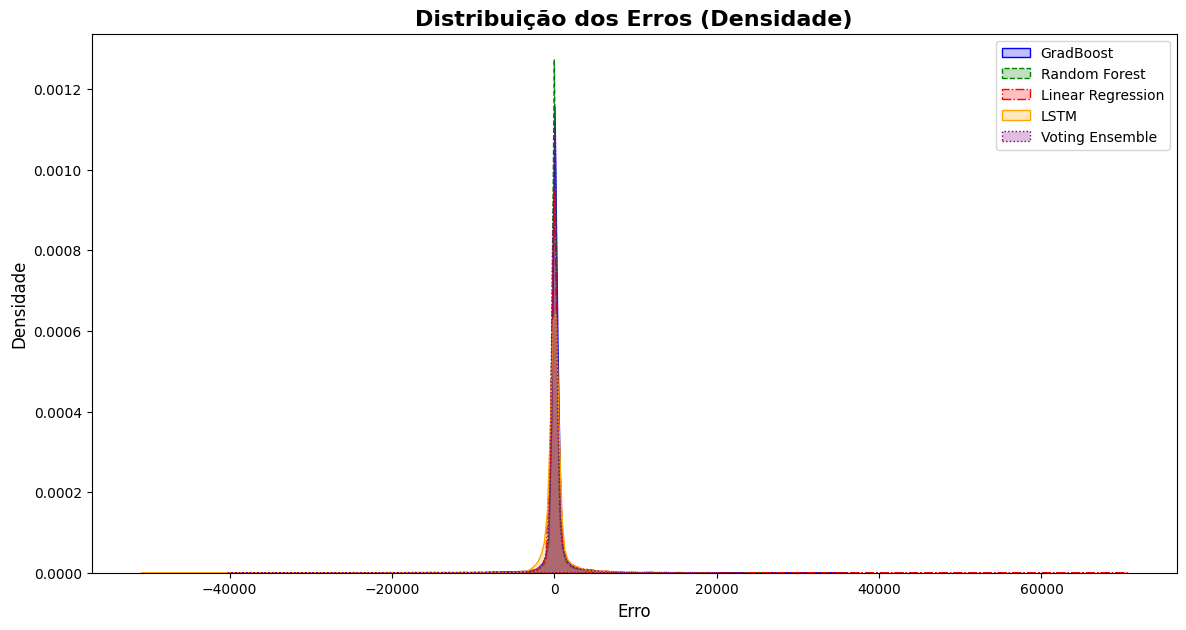

In [ ]:
# Calcular os erros (resíduos)
errors_gradboost = preds_gradboost - y_test
errors_rf = preds_rf - y_test
errors_rl = preds_rl - y_test
errors_lstm = preds_lstm - y_test
errors_voting = preds_voting_ensemble - y_test  # Erros do Voting Ensemble

# Criar um DataFrame para os erros
errors_df = pd.DataFrame({
    'Erro': np.concatenate([errors_gradboost, errors_rf, errors_rl, errors_lstm, errors_voting]),
    'Modelo': ['Gradboost'] * len(errors_gradboost) + ['Random Forest'] * len(errors_rf) + ['Linear Regression'] * len(errors_rl) + ['LSTM'] * len(errors_lstm) + ['Voting Ensemble'] * len(errors_voting)
})

# Plotar gráficos de densidade dos erros
plt.figure(figsize=(14, 7))
sns.kdeplot(errors_gradboost, label='GradBoost', fill=True, color='blue', linestyle='-')
sns.kdeplot(errors_rf, label='Random Forest', fill=True, color='green', linestyle='--')
sns.kdeplot(errors_rl, label='Linear Regression', fill=True, color='red', linestyle='-.')
sns.kdeplot(errors_lstm, label='LSTM', fill=True, color='orange', linestyle='-')
sns.kdeplot(errors_voting, label='Voting Ensemble', fill=True, color='purple', linestyle=':')
plt.title('Distribuição dos Erros (Densidade)', fontsize=16, fontweight='bold')
plt.xlabel('Erro', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.show()

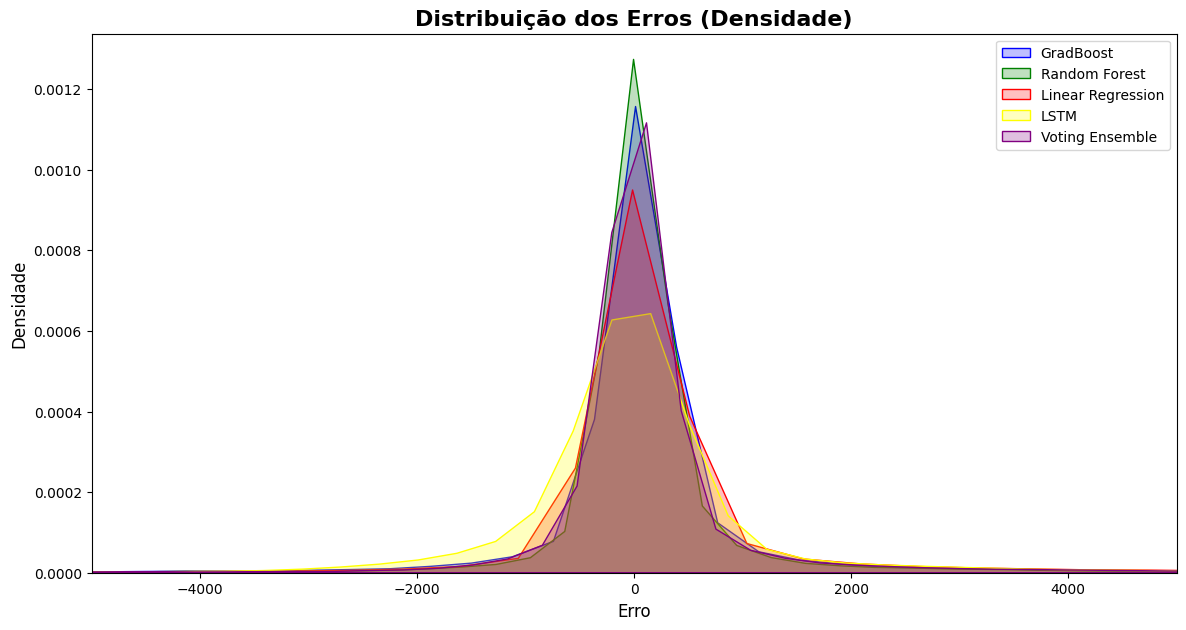

In [ ]:
# Ajustando escala do gráfico
plt.figure(figsize=(14, 7))
sns.kdeplot(errors_gradboost, label='GradBoost', fill=True, color='blue')
sns.kdeplot(errors_rf, label='Random Forest', fill=True, color='green')
sns.kdeplot(errors_rl, label='Linear Regression', fill=True, color='red')
sns.kdeplot(errors_lstm, label='LSTM', fill=True, color='yellow')
sns.kdeplot(errors_voting, label='Voting Ensemble', fill=True, color='purple')
plt.title('Distribuição dos Erros (Densidade)', fontsize=16, fontweight='bold')
plt.xlabel('Erro', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.xlim([-5000, 5000])  # Ajustar o limite conforme necessário
plt.legend()
plt.show()